# Part 1: Preliminary EDA

In this notebook, we will be analyzing the "Beer Reviews" dataset from Kaggle, uploaded by user "Datadoume". Our ultimate goal will be the construction of a beer recommendation algorithm. This dataset contains data from ~1.5 million beer reviews from the website "Beer Advocate".

ref: [Beer Review Dataset](https://www.kaggle.com/datasets/rdoume/beerreviews)

In [ ]:
%%capture
import sys
import os

# Add project root to Python path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
# import packages
from utils.imports import *

## Loading the data and basic data cleaning

In [59]:
# Download latest version
path = kagglehub.dataset_download("rdoume/beerreviews", path='beer_reviews.csv', force_download = True)

beer = pd.read_csv(path)

100%|██████████| 27.4M/27.4M [00:00<00:00, 75.7MB/s]


Let's take a quick look at our data.

In [60]:
print(len(beer))
beer.head()

1586614


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


We can see that each row represents a review ranking a beer on several qualities including an overall score. We also have some basic information about each beer reviewed, such as its type and the brewery producing the beer. Finally, we have some metadata: the date the review was posted, the username of the the user who posted the review, and unique identifiers for the breweries/beers. For the purposes of our analysis, we'll keep all the columns since they could all be useful.

Now let's see how many rows have missing values.

In [61]:
#sum rows with one or more null values
beer.isna().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

We can see from the above output that around 68000 rows have one or more null values and most of the missing values are the ABV (alcohol by volume). Since the number of rows with null values is low compared to the size of the  data set, in this case, we'll opt to discard the null values (we are going to use ABV in our analysis).

In [62]:
#remove nulls
beer = beer[-beer.isna().any(axis=1)]

We'll also look for duplicates in the data.

In [63]:
beer.duplicated().sum()

np.int64(0)

## Basic data analysis
Looks like we're good; no duplicates. At this point, we're ready to begin doing some preliminary analysis of the data. Let's see how many unique users, beers, and categories there are.

In [64]:
beer.nunique()

brewery_id               5230
brewery_name             5155
review_time           1510459
review_overall             10
review_aroma                9
review_appearance          10
review_profilename      32908
beer_style                104
review_palate               9
review_taste                9
beer_name               44075
beer_abv                  530
beer_beerid             49000
dtype: int64

In [65]:
#subset data
cols = ["review_overall", "review_aroma", "review_appearance",
        "review_palate", "review_taste"]
round(beer[cols].describe(), 2)

,review_overall,review_aroma,review_appearance,review_palate,review_taste
count,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00
mean,3.82,3.75,3.85,3.75,3.80
std,0.72,0.70,0.61,0.68,0.73
min,0.00,1.00,0.00,1.00,1.00
25%,3.50,3.50,3.50,3.50,3.50
50%,4.00,4.00,4.00,4.00,4.00
75%,4.50,4.00,4.00,4.00,4.50
max,5.00,5.00,5.00,5.00,5.00


/var/folders/b6/811_kpyj6yd5q_vzydsq8cbc0000gn/T/ipykernel_40334/3967134386.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


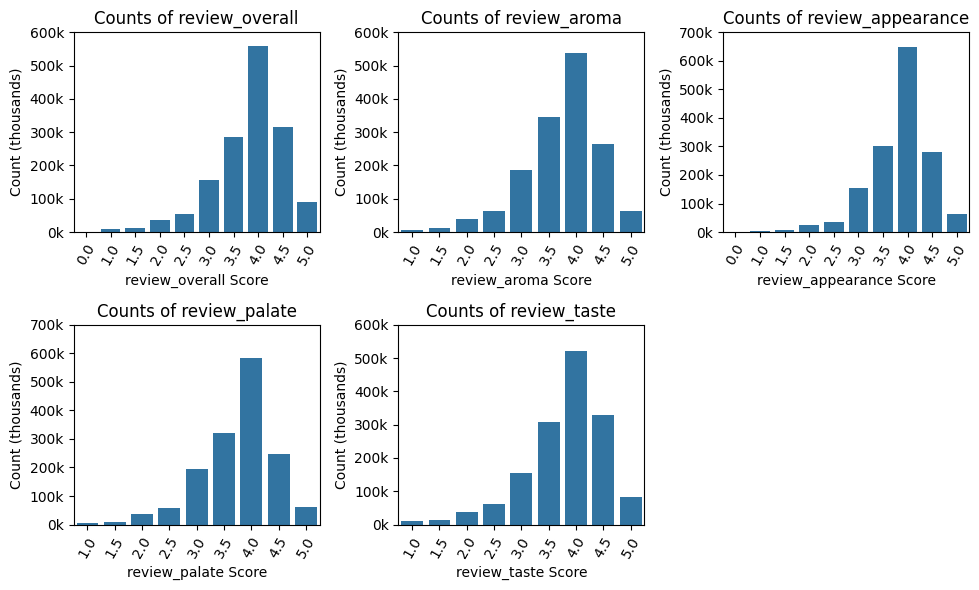

In [66]:
#create a subplots figure + axes
fig, axes = plt.subplots(2,3, figsize=(10,6))
#makes axes 1D
axes = axes.flatten()
#loop over axes and plot
for i in range(5):
        ax = axes[i]
        key = cols[i]
        sb.countplot(data=beer, x=cols[i], ax=ax)
        ax.tick_params(axis='x', rotation=60)
        ax.set_title(f'Counts of {key}')
        yticks = ax.get_yticks()
        ylabels = [f'{int(tick/1000)}k' for tick in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)
        ax.set_ylabel('Count (thousands)')
        ax.set_xlabel(f'{key} Score')
#show results
fig.tight_layout()
fig.delaxes(axes[5])
fig.show()

We can see from the above results that the distribution for each score is similar - 4.0 is the most common score, with scores of 5.0 or 2.5 and below being quite uncommon. All the score distributions exhibit left skew. 

## ABV
Let's look at ABV now.

In [67]:
#perform basic analysis at ABV data
round(beer['beer_abv'].describe(), 2)

count    1518478.00
mean           7.04
std            2.32
min            0.01
25%            5.20
50%            6.50
75%            8.50
max           57.70
Name: beer_abv, dtype: float64

We can see that there is a large range between the maximum and minimum values. Let's take a closer look at what a "typical" ABV value looks like.

In [68]:
quants = beer['beer_abv'].quantile([.5,.95])
quants

0.50     6.5
0.95    11.0
Name: beer_abv, dtype: float64

We can see that 90% of beers have ABV values between 0.95 and 11. Let's take a look at the distribution of beers within this range.

Text(0.5, 1.0, 'ABV Counts')

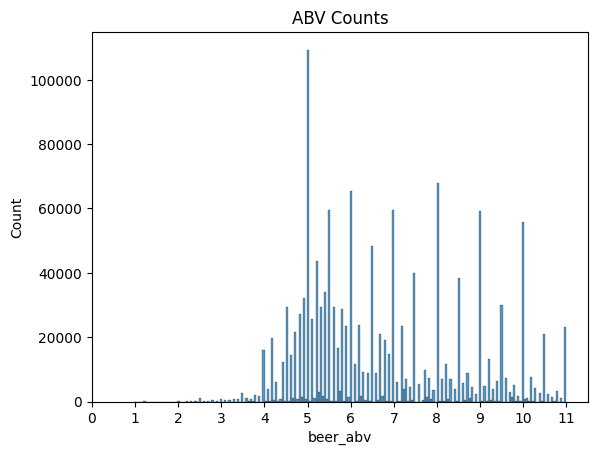

In [69]:
#let's plot the abv counts
ax = sb.histplot(data=beer, x='beer_abv', binrange=(.95,11))
ticks = list(range(12))
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.set_title('ABV Counts')

It appears that beers with an ABV of 5 are the most common. It also appears that whole numbers are better represented. For fun, let's take a look at beer with the highest ABV.

In [70]:
#find most alcoholic beer
beer.loc[beer['beer_abv'] == max(beer['beer_abv'])]

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
12919,6513,Schorschbräu,1316780901,4.0,4.0,4.0,kappldav123,Eisbock,4.0,3.5,Schorschbräu Schorschbock 57%,57.7,73368


A quick search indicates that this beer is real! Honestly, I would be very curious to try it. Let's find out how many beer categories there are.

In [71]:
#how many categories are there?
beer['beer_style'].nunique()

104

## Beer Categories
Let's look into the beer category data. The relatively small number of categories compared to the size of the overall dataset is a good sign; we expect that there shouldn't be too many mistyped/erroneous categories, if any. Let's take a quick look at the categories and some basic information about them.

In [72]:
#we'll run a SQL queries to group the data by beer style and generate some statistics
query = "SELECT beer_style, COUNT(DISTINCT beer_beerid) num_beers, \
    COUNT(*) as review_count, AVG(review_overall) as avg_rating, \
    MAX(beer_abv) as max_abv, MIN(beer_abv) as min_abv, \
    COUNT(DISTINCT review_profilename) as num_unique_reviewers, \
    review_count / num_unique_reviewers as reviews_per_user, \
    STDdev(review_overall) as stddev_rating \
    FROM beer GROUP BY beer_style"
#query and save
styles = db.sql(query).df()

In [73]:
#show 20 most popular styles
styles.sort_values('review_count', ascending = False).head(20)

,beer_style,num_beers,review_count,avg_rating,max_abv,min_abv,num_unique_reviewers,reviews_per_user,stddev_rating
95,American IPA,2503,113144,3.972212,11.0,0.50,12337,9.171111,0.608064
57,American Double / Imperial IPA,1297,85105,4.000323,41.0,5.50,10950,7.772146,0.635399
11,American Pale Ale (APA),2190,58072,3.870790,9.4,2.00,8995,6.456031,0.651478
94,Russian Imperial Stout,735,53424,4.024652,22.0,4.50,8965,5.959175,0.634853
29,American Double / Imperial Stout,816,50137,4.030536,39.0,4.50,8023,6.249159,0.666182
80,American Porter,1364,46647,3.909083,18.0,3.20,8281,5.633015,0.636014
73,American Amber / Red Ale,1599,41731,3.803012,13.0,2.50,8089,5.158981,0.660124
98,Belgian Strong Dark Ale,711,37498,3.914195,18.1,5.40,7472,5.018469,0.634074
36,Fruit / Vegetable Beer,1226,31983,3.418597,18.0,0.90,7232,4.422428,0.892533
28,American Strong Ale,598,31350,3.874689,27.0,4.77,7112,4.408043,0.697065


In [74]:
#show 20 least popular styles
styles.sort_values('review_count').head(20)

,beer_style,num_beers,review_count,avg_rating,max_abv,min_abv,num_unique_reviewers,reviews_per_user,stddev_rating
62,Kvass,19,229,3.368996,3.9,0.50,145,1.579310,1.049373
65,Happoshu,69,237,2.913502,7.0,3.00,103,2.300971,0.989300
24,Roggenbier,44,395,3.950633,8.0,4.20,321,1.230530,0.532658
92,Faro,19,608,3.600329,8.0,1.30,484,1.256198,0.763004
46,English Pale Mild Ale,116,648,3.648920,6.0,2.50,463,1.399568,0.776768
91,Gose,28,654,3.961774,6.0,3.70,533,1.227017,0.630448
103,Sahti,21,1004,3.697211,11.0,4.50,798,1.258145,0.707426
82,Braggot,58,1013,3.653011,16.5,4.20,713,1.420757,0.673308
31,Low Alcohol Beer,126,1020,2.551961,3.0,0.01,533,1.913696,1.020038
64,Lambic - Unblended,57,1039,4.060635,11.0,3.50,637,1.631083,0.661114


We can see that the more popular styles tend to have many more reviews per user compared to the less popular users - the users are trying one or two beers from the less popular styles, and several from the more popular styles. Let's plot reviews per user against review count to investigate this relaitonship.

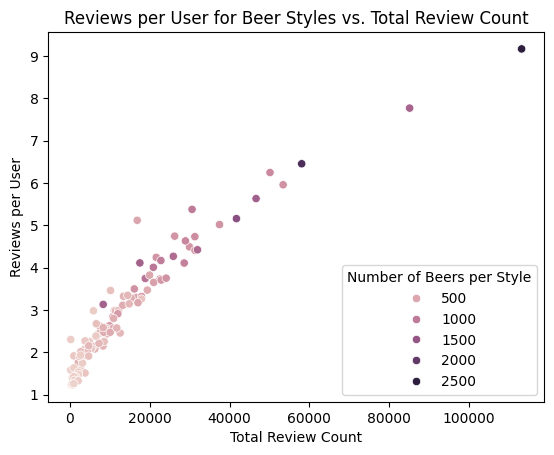

In [75]:
#scatterplot
sb.scatterplot(data=styles, x='review_count', y='reviews_per_user', hue='num_beers')
plt.title('Reviews per User for Beer Styles vs. Total Review Count')
plt.ylabel('Reviews per User')
plt.xlabel('Total Review Count')
plt.legend(title='Number of Beers per Style', loc='lower right')

There is a clear positive monotonic relationship between the overall number of reviews and the number of review per user for each category. This is not surprising, since there are many more reviews than there are users. What is more surprising is that the two variables are so closely related; almost all of the variance in reviews per user seems to be identified by some nonlinear function of total review count.

In [76]:
#show 20 styles with the highest ratings
styles.sort_values('avg_rating', ascending = False).head(20)

,beer_style,num_beers,review_count,avg_rating,max_abv,min_abv,num_unique_reviewers,reviews_per_user,stddev_rating
53,American Wild Ale,498,16886,4.100379,13.5,3.30,3299,5.118521,0.653677
9,Gueuze,86,5927,4.087397,10.1,4.00,1989,2.979889,0.640914
68,Quadrupel (Quad),181,17941,4.073156,15.0,7.20,5508,3.257262,0.629418
64,Lambic - Unblended,57,1039,4.060635,11.0,3.50,637,1.631083,0.661114
29,American Double / Imperial Stout,816,50137,4.030536,39.0,4.50,8023,6.249159,0.666182
94,Russian Imperial Stout,735,53424,4.024652,22.0,4.50,8965,5.959175,0.634853
16,Weizenbock,247,9251,4.011188,16.0,4.70,3612,2.561185,0.596756
57,American Double / Imperial IPA,1297,85105,4.000323,41.0,5.50,10950,7.772146,0.635399
90,Flanders Red Ale,113,6563,3.995810,11.0,3.50,2754,2.383079,0.674359
18,Rye Beer,291,9638,3.989106,12.5,3.80,3848,2.504678,0.592301


🎖️American Wild Ales are the overall most popular beer. I haven't heard of most of these styles before, time to start drinking!

Let's compare average review count and average score.

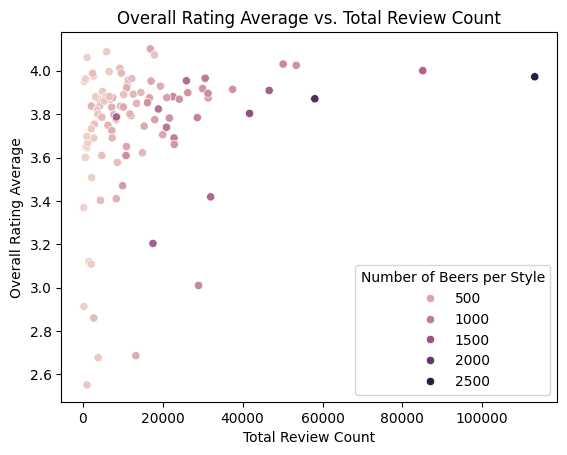

In [77]:
#scatterplot
sb.scatterplot(data=styles, x='review_count', y='avg_rating', hue='num_beers')
plt.title('Overall Rating Average vs. Total Review Count')
plt.ylabel('Overall Rating Average')
plt.xlabel('Total Review Count')
plt.legend(title='Number of Beers per Style')

We can see that the most popular styles of beer are also well-reviewed. This could be useful information when considering the cold start problem - more popular styles could be used as recommendations when there is little information about user preferences.

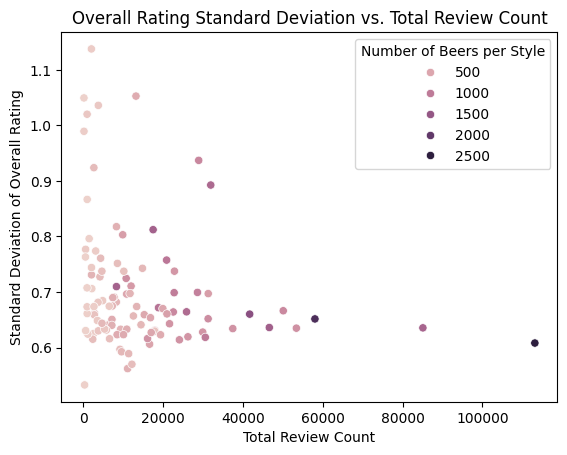

In [78]:
#scatterplot
sb.scatterplot(data=styles, x='review_count', y='stddev_rating', hue='num_beers')
plt.title('Overall Rating Standard Deviation vs. Total Review Count')
plt.ylabel('Standard Deviation of Overall Rating')
plt.xlabel('Total Review Count')
plt.legend(title='Number of Beers per Style')

We also see that the most polarizing styles of beer tend to be the least popular. The story from these two graphs is that the 7 most popular styles of beer are essentially agreed-upon to be "pretty good".

## Pairwise rating relationships
At this point, we're ready to start looking into the relationships between the variables. Let's take a look at the pairwise distributions between review scores.

/var/folders/b6/811_kpyj6yd5q_vzydsq8cbc0000gn/T/ipykernel_40334/1393477205.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


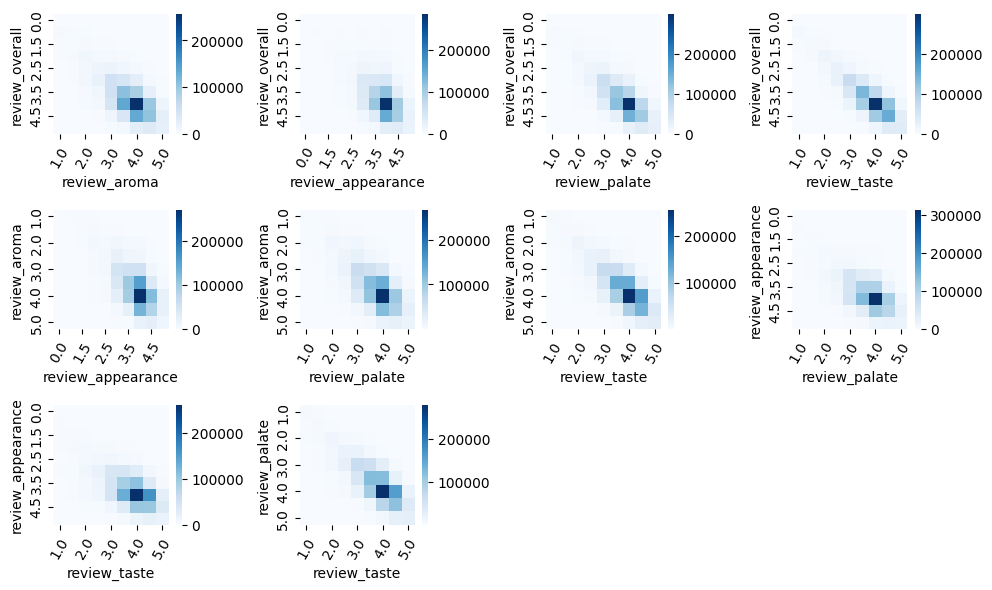

In [79]:
#generate cross-combinations for review scores
#get all pairs of raitng variables
from itertools import combinations
pairs = list(combinations(cols, 2))

#create a subplots figure + axes
fig, axes = plt.subplots(3,4, figsize=(10,6))
#makes axes 1D
axes = axes.flatten()
#loop over axes and plot
for i in range(10):
        #select correct axis
        ax = axes[i]
        #generate crosstable of variables
        cross = pd.crosstab(beer[pairs[i][0]], beer[pairs[i][1]])
        #plot pairwise heatmap
        sb.heatmap(cross, cmap='Blues', ax=ax)
        ax.tick_params(axis='x', rotation=60)
#show results
fig.tight_layout()
fig.delaxes(axes[10])
fig.delaxes(axes[11])
fig.show()

In all the pairwise distributions, the most common outcome is a score of 4 on both ratings, and in general the distributions appear similar - as we saw earlier from the univariate distribution plots, scores most commonly rnage between 3 and 4.5. We'll have to do some analysis to uncover more details about the relationships between the variables.

Let's begin by taking a correlation measure between the score variables. We shouldn't use the Pearson correlation, since it's only valid for continuous and normally distributed data with a linear relationship. Our review score variables are ordinal, so instead, we can use Spearman rank correlation and Kendall's Tau correlation.

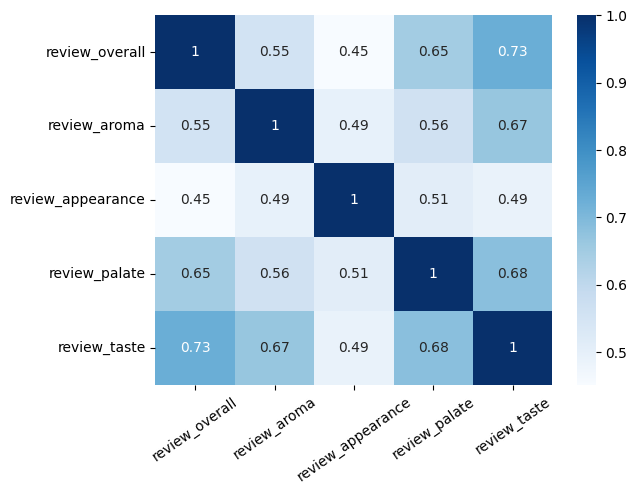

In [80]:
#get spearman correlation matrix for review scores and plot
corr = sb.heatmap(beer[cols].corr(method='spearman'), cmap='Blues', annot=True)
corr.tick_params(axis = 'x', rotation=35)

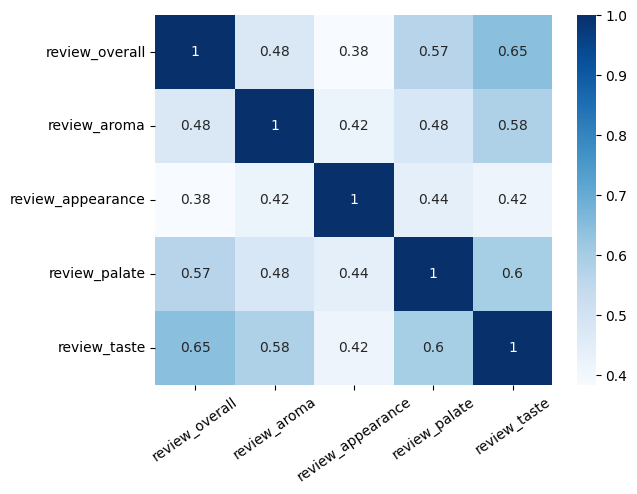

In [81]:
#get kendall correlation matrix for review scores and plot
corr = sb.heatmap(beer[cols].corr(method='kendall'), cmap='Blues', annot=True)
corr.tick_params(axis = 'x', rotation=35)

When comparing two review score variables $x,y$, we say a pair of data points $\{(x_i, y_i), (x_j,y_j)\}$ is *tied* if and only if $x_i = x_j$ or $y_i = y_j$. One feature of our data is that when calculating Spearman or Tau correlations, there will be many pairs. This is because the scores can only be chosen between $0$ and $5$ at intervals of $0.5$, with scores of 4.0 being common for all variables. For example, there are likely to be many ties where $(x_i,y_i) = (x_j,y_j) = (4.0,4.0)$. Let's get some pairwise counts of such ties, just for fun.

In [82]:
#calculate proportion of pairwise data points where review scores are both 4.0
for i in range(10):
    pair = pairs[i]
    print(pair)
    print(
        #get number of rows where scores equal 4.0 and divide by overall length
        round(beer[(beer[pair[0]] == 4.0) & (beer[pair[1]] == 4.0)].shape[0]
              /beer.shape[0],2))

('review_overall', 'review_aroma')
0.17
('review_overall', 'review_appearance')
0.19
('review_overall', 'review_palate')
0.2
('review_overall', 'review_taste')
0.2
('review_aroma', 'review_appearance')
0.18
('review_aroma', 'review_palate')
0.18
('review_aroma', 'review_taste')
0.17
('review_appearance', 'review_palate')
0.21
('review_appearance', 'review_taste')
0.17
('review_palate', 'review_taste')
0.18


As expected, we have a significant amount of ties. It's unsurprising, then, that the Kendall's Tau-b correlation values are smaller than the Spearman rho values, since the rho values can be inflated in the presence of many ties. Otherwise, the two correlation measures correspond closely in terms of the the relative pairwise magnitudes. Perhaps unsurprisingly, both correlation measures indicate the strongest relationship is between taste and overall score, and the weakest relationship is between appearance and overall score. After all, when we drink a glass of beer, we care more about how it tastes than how it looks.

# Part 2: Pouring over the dataset (Targeted EDA)
## 2.1 User Data
Now that we've performed some basic analysis on our data, we're ready to move to some more detailed/targeted EDA. Let's start by finding out some information about our userbase.

In [83]:
#how many users do we have?
query = "SELECT COUNT(*) num_of_users FROM (SELECT DISTINCT review_profilename FROM beer)"
db.sql(query)

┌──────────────┐
│ num_of_users │
│    int64     │
├──────────────┤
│        32908 │
└──────────────┘

In [84]:
#let's use SQL to group by user and get the review count and average review scores
query = "SELECT review_profilename, AVG(review_overall) avg_overall, \
    AVG(review_aroma) ag_aroma, AVG(review_appearance) avg_appearance, \
    AVG(review_palate) avg_palate, AVG(review_taste) avg_taste, \
    STDDEV(review_overall) stddev_overall, \
    COUNT(*) num_reviews FROM beer \
    GROUP BY review_profilename ORDER BY review_profilename"
#use duckdb to query the data
user_scores = db.sql(query).df()

#what's the maximum number of reviews for a single user?
query = "SELECT num_reviews FROM user_scores ORDER BY num_reviews DESC LIMIT 1"
db.sql(query)

┌─────────────┐
│ num_reviews │
│    int64    │
├─────────────┤
│        5346 │
└─────────────┘

That's a lot of beer.

In [85]:
#let's see how many users have 1 review
query = "SELECT COUNT(*) users_with_1_review FROM user_scores WHERE num_reviews = 1"
db.sql(query)


┌─────────────────────┐
│ users_with_1_review │
│        int64        │
├─────────────────────┤
│               10270 │
└─────────────────────┘

Almost 30% of users have only made one review! It appears that we are not safe from the infamous "cold start" problem. Cold start mitigation strategies will be discussed in the project write-up. Let's look at how the proportion of users with certain numbers of reviews; this will be important when determining thresholds to train our data on.

In [86]:
#count unique # of users
nusers = user_scores.nunique().iloc[0]
pct=[]
# set thresholds for review counts
t = [3, 5,10,20,50]
# calculate the percentage of users with at least the specified number of reviews
for i in t:
    pct.append(round((user_scores.query('num_reviews >= @i').shape[0] / nusers) * 100, 2))
    print(f'number of users with at least {i} reviews: {pct[-1]}%')

number of users with at least 3 reviews: 56.53%
number of users with at least 5 reviews: 44.4%
number of users with at least 10 reviews: 32.16%
number of users with at least 20 reviews: 23.06%
number of users with at least 50 reviews: 14.34%


In [87]:
#we'll also look at the proportion of total reviews we have after filtering for certain thresholds
# count number of reviews in the original dataset
total_reviews = beer.shape[0]
for i in t:
    #get dataframe for users with at least i reviews and calculate proportion of total reviews
    u = beer.groupby('review_profilename').filter(lambda x: len(x) > i)
    prop = round((u.shape[0] / total_reviews) * 100, 2)
    #print the pct of total reviews remaining
    print(f'proportion of total reviews after filtering for users with at least {i} reviews: \
        {prop}')
    


proportion of total reviews after filtering for users with at least 3 reviews:         98.32
proportion of total reviews after filtering for users with at least 5 reviews:         97.5
proportion of total reviews after filtering for users with at least 10 reviews:         95.81
proportion of total reviews after filtering for users with at least 20 reviews:         93.24
proportion of total reviews after filtering for users with at least 50 reviews:         87.42


It seems that a large amount of our reviews are coming from highly active users. That is to say, 14.34% of users are posting 87.42% of the reviews!

Now, let's have a closer look at the distribution of review counts and average scores. 

**For the review counts, we have a broad range of values to compare, so we'll plot the x-axis using the log-scale.**

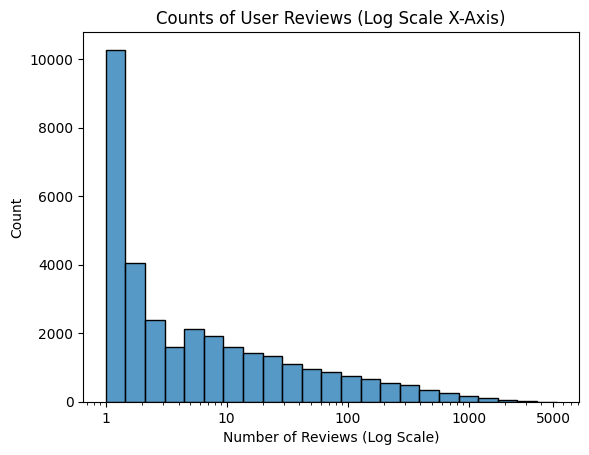

In [88]:
#tool for formatting axis
from matplotlib.ticker import ScalarFormatter
#create figure and axis
fig, ax = plt.subplots()
#plot histogram of user scores
sb.histplot(data = user_scores, x='num_reviews', ax = ax, log_scale=(True,False), binwidth=.16)
#format x axis
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([1,10,100,1000,5000])
#label
ax.title.set_text('Counts of User Reviews (Log Scale X-Axis)')
ax.set_xlabel('Number of Reviews (Log Scale)')
plt.show()

From the histogram, we can see that the number of reviews appears to roughly fit a "power law distribution". Of course, our data is discrete so the power law distribution doesn't apply.

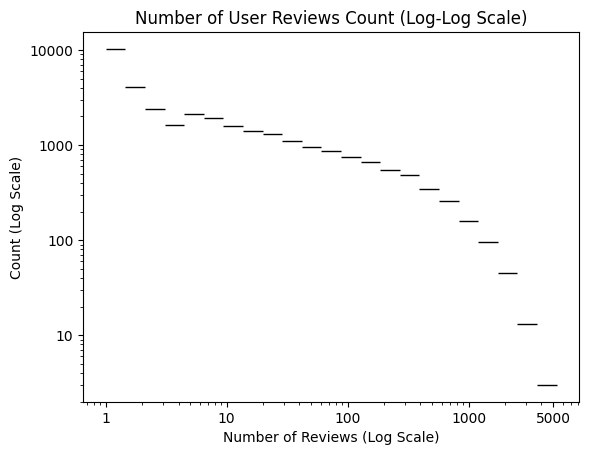

In [89]:
#tool for formatting axis
from matplotlib.ticker import ScalarFormatter
#create figure and axis
fig, ax = plt.subplots()
#plot histogram of user scores
sb.histplot(data = user_scores, x='num_reviews', ax = ax, 
            log_scale=(True,True), #both axes on log scale
             binwidth=.16)
#format x and y axis
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([1,10,100,1000,5000])
#label
ax.title.set_text('Number of User Reviews Count (Log-Log Scale)')
ax.set_xlabel('Number of Reviews (Log Scale)')
ax.set_ylabel('Count (Log Scale)')
plt.show()

If the data really was similar to a power-law distribution, the relationship between number of reviews and count would look roughly linear. We can see that the "middle" of the data is roughly linear, and therefore approximates a power law distribution. The left tail curving up indicates that there are more users with a low review count than if the truly followed a power law distrbution. The right tail curving down indicates that there are even fewer users with many reviews compared to power law distributed data.

We'd like to get an idea of how users behave. Let's look at average user review scores.

/var/folders/b6/811_kpyj6yd5q_vzydsq8cbc0000gn/T/ipykernel_40334/3690083866.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


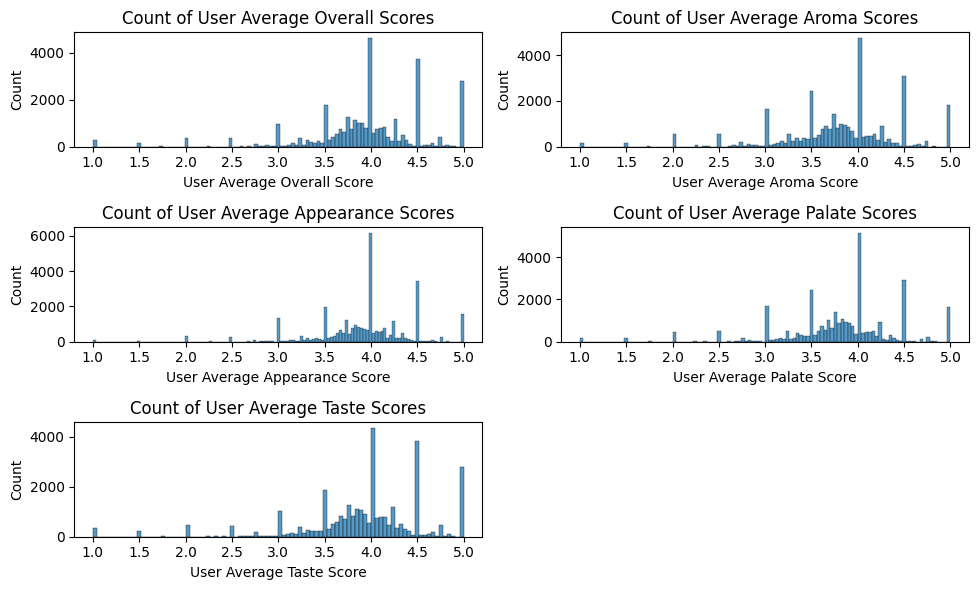

In [90]:
#create a subplots figure + axes
fig, axes = plt.subplots(3,2, figsize=(10,6))
#makes axes 1D
axes = axes.flatten()
cols = user_scores.columns[1:6].tolist()
titles = ['Overall', 'Aroma', 'Appearance', 'Palate', 'Taste']
#loop over axes and plot
for i in range(5):
        #select correct axis
        ax = axes[i]
        key = titles[i]
        #plot histogram of user scores
        sb.histplot(data = user_scores, x=cols[i], ax = ax)
        #label
        ax.title.set_text(f'Count of User Average {key} Scores')
        ax.set_xlabel(f'User Average {key} Score')
        ax.set_ylabel('Count')

#show results
fig.tight_layout()
fig.delaxes(axes[5])
fig.show()

We see that the averages are getting "spiked" on 1.0, 1.5, etc., most likely because users with a single review will only have been able to select these values. Let's look at the distributions when we only look at users with >=5 reviews.

In [91]:
#let's use SQL to group by user and get the review count and average review scores
#but this time we exclude users with only 1 review
query = "SELECT review_profilename, AVG(review_overall) avg_overall, \
    AVG(review_aroma) ag_aroma, AVG(review_appearance) avg_appearance, \
    AVG(review_palate) avg_palate, AVG(review_taste) avg_taste, \
    STDDEV(review_overall) stddev_overall, \
    COUNT(*) num_reviews FROM beer \
    GROUP BY review_profilename \
    HAVING COUNT(*)>=5 ORDER BY review_profilename"
#use duckdb to query the data
user_multi_scores = db.sql(query).df()

/var/folders/b6/811_kpyj6yd5q_vzydsq8cbc0000gn/T/ipykernel_40334/476267563.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


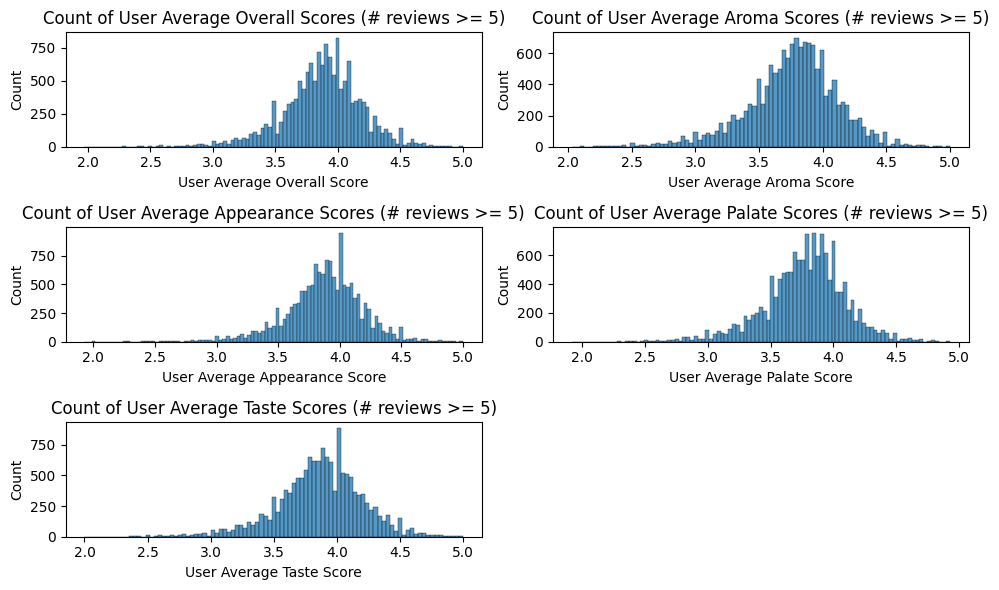

In [92]:
#create a subplots figure + axes
fig, axes = plt.subplots(3,2, figsize=(10,6))
#makes axes 1D
axes = axes.flatten()
#loop over axes and plot
for i in range(5):
        #select correct axis
        ax = axes[i]
        key = titles[i]
        #plot histogram of user scores
        sb.histplot(data = user_multi_scores, x=cols[i], ax = ax)
        #label
        ax.title.set_text(f'Count of User Average {key} Scores (# reviews >= 5)')
        ax.set_xlabel(f'User Average {key} Score')
        ax.set_ylabel('Count')

#show results
fig.tight_layout()
fig.delaxes(axes[5])
fig.show()

We can immediately see that the "spikes" on multiples of $\frac{1}{2}$ are much less pronounced (though still present). In general, scores for most attributes tend to "spike" at 3.5, 4, and 4.5, with the most density otherwise between 3.5 and 4.

Let's plot user average review score and variance.

Text(0.5, 0, 'Total Review Count')

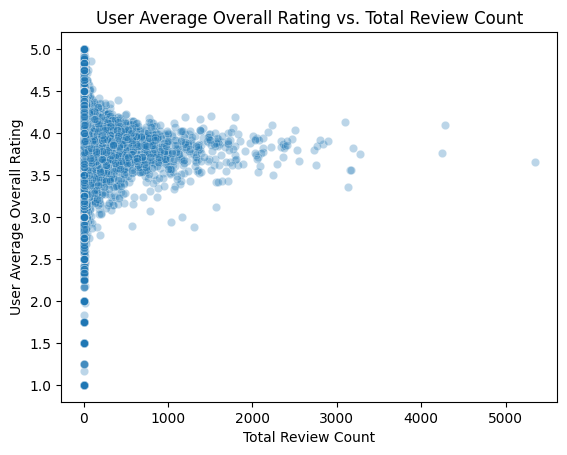

In [93]:
#scatterplot
sb.scatterplot(data=user_scores, x='num_reviews', y='avg_overall', alpha=0.3)
plt.title('User Average Overall Rating vs. Total Review Count')
plt.ylabel('User Average Overall Rating')
plt.xlabel('Total Review Count')

Text(0.5, 0, 'Total Review Count')

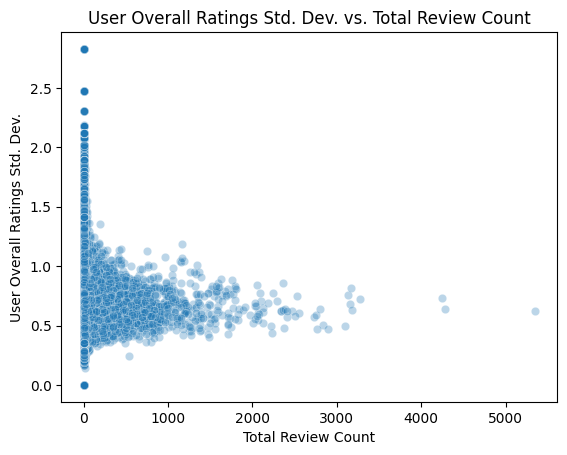

In [94]:
#scatterplot
sb.scatterplot(data=user_scores, x='num_reviews', y='stddev_overall', alpha=0.3)
plt.title('User Overall Ratings Std. Dev. vs. Total Review Count')
plt.ylabel('User Overall Ratings Std. Dev.')
plt.xlabel('Total Review Count')

We see that in general, we observe extreme standard deviation and average scores only from reviewers with a very small number of reviews. As the number of reviews increases, the range of values tends to decrease.

## 2.2 Beer Data
We would also like to take a look at the data from a product perspective. We can calculate and visualize some statistics as aggregated by beer types, like we did for users.

In [95]:
#let's use SQL to group by user and some statistics for individual products
query = "SELECT beer_beerid as beer_id, beer_name, brewery_name, beer_style, \
    AVG(review_overall) avg_overall, AVG(review_aroma) ag_aroma, \
    AVG(review_appearance) avg_appearance, \
    AVG(review_palate) avg_palate, AVG(review_taste) avg_taste, \
    STDDEV(review_overall) stddev_overall, \
    COUNT(*) num_reviews FROM beer \
    GROUP BY beer_beerid, beer_name, brewery_name, beer_style \
    ORDER BY beer_beerid"
#use duckdb to query the data
beer_types = db.sql(query).df()
#show header for validation
beer_types.head()

,beer_id,beer_name,brewery_name,beer_style,avg_overall,ag_aroma,avg_appearance,avg_palate,avg_taste,stddev_overall,num_reviews
0,5,Amber,Abita Brewing Co.,Vienna Lager,3.549528,3.205189,3.485849,3.318396,3.340802,0.676278,424
1,6,Turbodog,Abita Brewing Co.,English Brown Ale,3.706956,3.515964,3.836374,3.513113,3.645382,0.629096,877
2,7,Purple Haze,Abita Brewing Co.,Fruit / Vegetable Beer,3.266313,3.179059,3.251138,3.106980,3.101669,0.823304,659
3,8,Wheat,Abita Brewing Co.,American Adjunct Lager,3.647059,3.080882,3.294118,3.301471,3.235294,0.872716,68
4,9,Golden,Abita Brewing Co.,American Pale Lager,3.400862,2.853448,3.051724,3.103448,3.043103,0.746644,116


In [96]:
#how many beers are there?
beer_types['beer_id'].nunique()

49000

Like we did for the users, we'd like to look at how filtering for certain threshreview count thresholdsodls impacts our dataset.

In [97]:
nbeers = beer_types.nunique().iloc[0]
pct=[]
# reminder : t = [3, 5,10,20,50]
for i in t:
    pct.append(round((user_scores.query('num_reviews >= @i').shape[0] / nbeers) * 100, 2))
    print(f'number of beers with at least {i} reviews: {pct[-1]}%')

number of beers with at least 3 reviews: 37.96%
number of beers with at least 5 reviews: 29.82%
number of beers with at least 10 reviews: 21.6%
number of beers with at least 20 reviews: 15.49%
number of beers with at least 50 reviews: 9.63%


In [98]:
#we'll also look at the proportion of total reviews we have after filtering for certain thresholds
# count number of reviews in the original dataset
for i in t:
    #get dataframe for users with at least i reviews and calculate proportion of total reviews
    b = beer.groupby('beer_beerid').filter(lambda x: len(x) > i)
    prop = round((b.shape[0] / total_reviews) * 100, 2)
    #print the pct of total reviews remaining
    print(f'proportion of total reviews after filtering for beers with at least {i} reviews: \
        {prop}')

proportion of total reviews after filtering for beers with at least 3 reviews:         97.2
proportion of total reviews after filtering for beers with at least 5 reviews:         95.82
proportion of total reviews after filtering for beers with at least 10 reviews:         93.29
proportion of total reviews after filtering for beers with at least 20 reviews:         89.63
proportion of total reviews after filtering for beers with at least 50 reviews:         82.22


Se see a drastic tail again: 9.63% of beers have 82.22% of the total reviews.

Let's take a look at the highest-rated beers.

In [99]:
beer_types.sort_values('avg_overall', ascending=False).head(20)

,beer_id,beer_name,brewery_name,beer_style,avg_overall,ag_aroma,avg_appearance,avg_palate,avg_taste,stddev_overall,num_reviews
31801,52938,WheatWine,Square One Brewery,Wheatwine,5.0,4.50,4.00,4.50,4.50,NaN,1
46741,74232,Inaugural Old Ale,Black Swan Brewpub,Old Ale,5.0,4.00,4.50,4.50,4.50,NaN,1
34672,57086,Emperor Wolf,Lovejoy's Taproom,American Double / Imperial Stout,5.0,4.00,5.00,5.00,3.50,NaN,1
18821,33014,Triple 7 India Pale Ale,America's Brewpub,American IPA,5.0,4.50,5.00,4.00,4.00,NaN,1
35418,58181,Myna Bock,Great Waters Brewing,Maibock / Helles Bock,5.0,4.00,4.00,4.50,4.50,NaN,1
31293,52107,Bubba Imperial Pilsner,Good People Brewing Company,American Double / Imperial Pilsner,5.0,4.75,3.50,4.25,5.00,0.0,2
36326,59650,3 Threads,McKenzie Brew House,Saison / Farmhouse Ale,5.0,4.00,3.50,4.50,5.00,NaN,1
37453,61353,Hopnitized,Brickstone Restaurant & Brewery,American IPA,5.0,4.50,5.00,4.00,4.50,NaN,1
39074,63735,Biere Blanche,Ninkasi Fabriques,Witbier,5.0,4.00,4.00,4.50,4.50,NaN,1
5389,9137,Triple Toison D'Or,Brouwerij Het Anker,Tripel,5.0,5.00,4.50,4.00,5.00,NaN,1


The beers with only one or two reviews can have very high ratings, so we'll have to account for this in our model. Possibly, we'll exclude beers under a certain review threshold. What happens when we exclude beers with less than 5 reviews?

In [100]:
beer_types[beer_types['num_reviews'] >= 5].sort_values('avg_overall', ascending=False).head(20)

,beer_id,beer_name,brewery_name,beer_style,avg_overall,ag_aroma,avg_appearance,avg_palate,avg_taste,stddev_overall,num_reviews
43655,70054,Alesmith Speedway Stout - Vanilla And Coconut,AleSmith Brewing Company,American Double / Imperial Stout,4.937500,5.000000,4.625000,4.937500,4.937500,0.176777,8
21298,37070,Iceberg Strong Pale Ale,Spinnakers Gastro Brewpub & Guesthouse,American Pale Ale (APA),4.916667,4.333333,4.000000,4.416667,4.750000,0.204124,6
36694,60204,Your Mother,The Alchemist Pub & Brewery,German Pilsener,4.900000,4.300000,4.200000,4.300000,4.400000,0.223607,5
28181,47503,Old Pappy Wheat Wine,Sacramento Brewing Co.,American Barleywine,4.900000,4.700000,4.300000,4.300000,4.700000,0.223607,5
16722,29236,The Inkwell 2005,Offshore Ale Company,American Double / Imperial Stout,4.857143,4.214286,4.285714,4.642857,4.785714,0.243975,7
40498,65686,Coffee Infused Imperial Stout Trooper,New England Brewing Co.,American Double / Imperial Stout,4.857143,4.500000,4.785714,4.714286,4.642857,0.243975,7
36524,59949,El Gordo,Good People Brewing Company,Russian Imperial Stout,4.857143,4.857143,4.928571,4.642857,4.857143,0.243975,7
32516,54147,Veritas 005,The Lost Abbey,American Wild Ale,4.846154,4.653846,4.461538,4.538462,4.807692,0.315213,13
26429,44910,Dirty Horse,De Struise Brouwers,Lambic - Unblended,4.820513,4.615385,4.423077,4.576923,4.743590,0.292160,39
34088,56266,Cascade Sang Noir,Cascade Brewing / Raccoon Lodge & Brewpub,American Wild Ale,4.807692,4.538462,4.307692,4.423077,4.923077,0.325222,13


In [101]:
beer_types[beer_types['num_reviews'] >= 5].sort_values('avg_overall').head(20)

,beer_id,beer_name,brewery_name,beer_style,avg_overall,ag_aroma,avg_appearance,avg_palate,avg_taste,stddev_overall,num_reviews
18670,32748,El Lapino,Microbrasserie du Lièvre,Chile Beer,1.136364,1.772727,1.636364,1.409091,1.318182,0.323335,11
18638,32690,Pit Bull,"City Brewing Company, LLC",American Malt Liquor,1.153846,1.346154,1.846154,1.230769,1.153846,0.315213,13
15466,27217,Evil Eye Red,Melanie Brewing Company,Fruit / Vegetable Beer,1.166667,1.750000,1.750000,1.333333,1.166667,0.258199,6
4839,8201,Mongoose Malt Liquor,Lakeport Brewing Company,American Malt Liquor,1.187500,1.500000,1.750000,1.437500,1.312500,0.530330,8
21053,36683,Jaguar High Gravity Lager,Melanie Brewing Company,American Malt Liquor,1.208333,1.583333,2.541667,1.833333,1.375000,0.334279,12
33529,55523,Griffes Du Diable,Groupe Geloso,American Malt Liquor,1.214286,1.357143,2.428571,1.428571,1.714286,0.393398,7
25401,43360,Raspberry Ale,Indian Wells Brewing Company,Fruit / Vegetable Beer,1.233333,1.766667,1.933333,1.500000,1.300000,0.457738,15
1570,2373,Dixie White Moose,Dixie Brewing Co.,Fruit / Vegetable Beer,1.250000,1.531250,1.718750,1.375000,1.343750,0.547723,16
16047,28102,Horus,Cervecera Mexicana S.A. De C.V.,Herbed / Spiced Beer,1.300000,1.600000,1.900000,1.700000,1.500000,0.447214,5
16309,28541,Thunder,Steelback Brewery,Euro Strong Lager,1.357143,1.428571,1.642857,1.500000,1.357143,0.626783,7


We can see that the highest and lowest-rated beers tend to have a small number of reviews. We'll need to consider this when we're building our model. Let's see if any beers were reviewed more than once by the same user.

In [102]:
#are there any beers that were reviewed by the same user more than once?
query = "SELECT review_profilename, beer_beerid \
    FROM beer GROUP BY review_profilename, beer_beerid\
    HAVING COUNT(*)>1 \
    ORDER BY review_profilename, beer_beerid"
#use duckdb to query the data
db.sql(query).df()

,review_profilename,beer_beerid
0,100floods,30420
1,11osixBrew,1904
2,11osixBrew,15589
3,1759Girl,386
4,1759Girl,1904
...,...,...
13933,zoso1967,19960
13934,zoso1967,53962
13935,zoso493,602
13936,zrab11,39


in fact, there are quite a few duplicated reviews. We'll have to deal with these when building the model.

Only 5 beers.

Text(0, 0.5, 'Count')

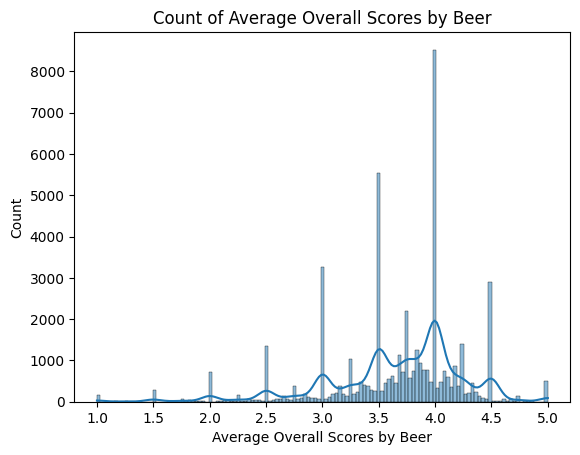

In [103]:
#first we'll plot average overall scores for beers
p = sb.histplot(data=beer_types, x='avg_overall', kde=True)
#label
p.title.set_text('Count of Average Overall Scores by Beer')
p.set_xlabel('Average Overall Scores by Beer')
p.set_ylabel('Count')

It's very common for beers to have average scores on the "round" values (3.5, 4.0, etc.). Notice how spikey the kde is.

In [104]:
#how many beers have only one review?
(beer_types['num_reviews']==1).sum()

np.int64(15617)

Text(0, 0.5, 'Count')

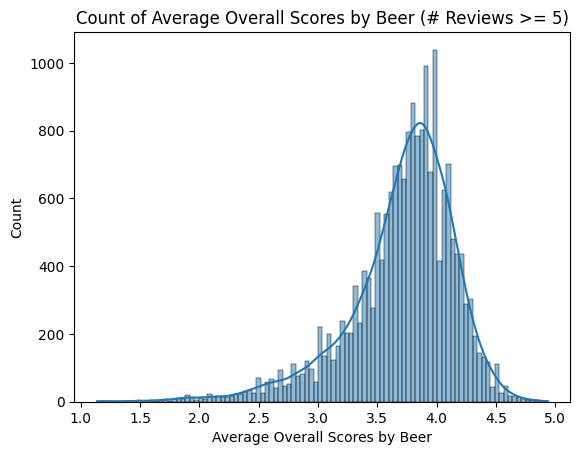

In [105]:
#plot again but only include beers with at least three reviews
p = sb.histplot(data=beer_types[beer_types['num_reviews'] >= 5], x='avg_overall', kde=True)
#label
p.title.set_text('Count of Average Overall Scores by Beer (# Reviews >= 5)')
p.set_xlabel('Average Overall Scores by Beer')
p.set_ylabel('Count')

We still see "spikes", but the kde is much smoother. We definitely see some left skew.

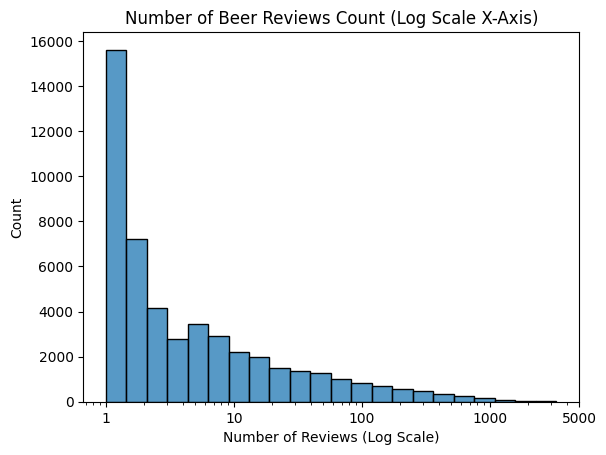

In [106]:
#how many reviews do the beers have?
#create figure and axis
fig, ax = plt.subplots()
#plot histogram of user scores
sb.histplot(data = beer_types, x='num_reviews', ax = ax, log_scale=(True,False), binwidth=.16)
#format x axis
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([1,10,100,1000,5000])
#label
ax.title.set_text('Number of Beer Reviews Count (Log Scale X-Axis)')
ax.set_xlabel('Number of Reviews (Log Scale)')
plt.show()

Unsurprisingly, we see that many beers have only one review.

We saw previously in the analysis of beer styles that the more popular styles also had relatively low variance and higher review scores. Let's look at the same information for individual beers.

Text(0.5, 0, 'Total Review Count')

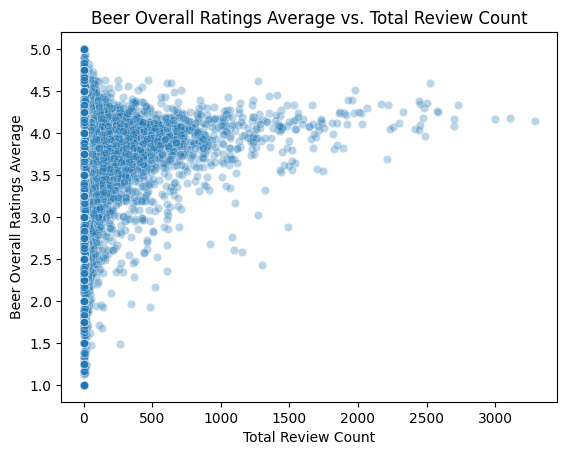

In [107]:
#scatterplot
sb.scatterplot(data=beer_types, x='num_reviews', y='avg_overall', alpha=0.3)
plt.title('Beer Overall Ratings Average vs. Total Review Count')
plt.ylabel('Beer Overall Ratings Average')
plt.xlabel('Total Review Count')

Text(0.5, 0, 'Total Review Count')

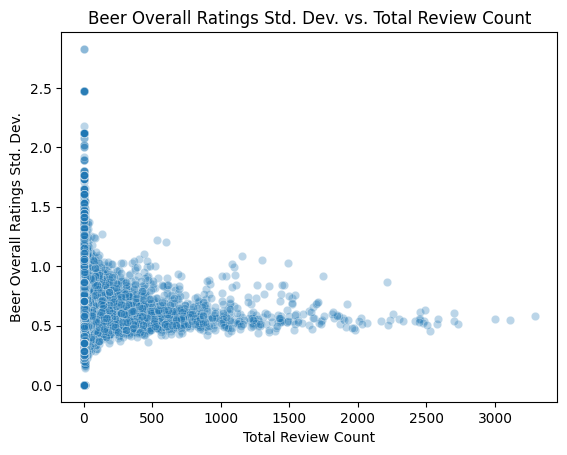

In [108]:
#scatterplot
sb.scatterplot(data=beer_types, x='num_reviews', y='stddev_overall', alpha=0.3)
plt.title('Beer Overall Ratings Std. Dev. vs. Total Review Count')
plt.ylabel('Beer Overall Ratings Std. Dev.')
plt.xlabel('Total Review Count')

Let's start building our model now.